# Virus spreading simulator 

This is simple simulator program for modeling the virus spreading using the actual mechanisms (sneezing) for the virus transfer. 

The simulator models the persons and their common locations (home, work, school, shops). When person is sick, the virus makes the person sneeze, which then transfers the virus to the nearby persons. 

The code is built to support vaccinations and other countermeasure options.

(c) Mikko Kursula, 2020, MIT License. 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time 
from multiprocessing import Pool

from person import Person
from virus import Virus
from event import Home, Work, School, Shop
from visuals import plot_sick_ratio, plot_cumul_inf_ratio
from run_sim import run_simulation
from analysis import cumul_inf_ratio

### Setup the simulation scenario

This function puts everything together and defines the simulation scenario. 

In [2]:
def setup_simulation(virus : Virus, 
                     n_home : int = 200,
                     n_work : int = 15,
                     n_school : int = 10,
                     n_shop : int = 2,
                     n_sick : int = 4,
                     n_adults_per_home = [1, 2],
                     n_kids_per_home = [0, 6],
                     vaccinated_ratio : float = 0, 
                     sick_leave_ok_ratio : float = 0, 
                     random_seed : int = 42
                    ) -> dict:
    """
    Simulation scenario setup. All locations (homes etc.), persons and the initial infections 
    are created here. 
    
    In home, school, work and shop setup the size parameter defines the bounding box for the  
    place and the persons are randomly located inside that box. Larger size means less likely 
    virus transfer. The dimensions are in meters. Virus transfer affects only the persons
    assigned to that location and the virus will not transfer outside of the box. 
    
    People are assigned to homes, schools, workplaces, etc. These are set at the beginning 
    of simulation and those remain constant, i.e. the persons will always return to the 
    same home and will always go to the same workplace. Note that e.g. the larger the number 
    of different workplaces, the less persons there will be per workplace if the number of 
    persons is kept constant. The number of workplaces, schools and shops can be used to 
    test social distancing. 
    
    The schedules of different location/event visits is setup in person event schedule 
    at one hour granularity level. The setup covers one full day of life that repeats as such 
    indefinitely. Only possible change to the scheduling is when person is sick and the
    person is allowed to stay at home when sick, in which case the person stays at 
    home until the disease has healed. 
    
    Each day the kids go to school and adults go to work. Randomly picked adults will 
    also visit at shop. 
    
    The virus setup includes the contagious time window (in hours), time to heal and other 
    basic parameters. 
    
    At the end of this function the initial virus infections are created as a 
    starting condition for the simulation. 
    
    This function returns the person and event instances that can be used to run 
    the simulation. 
    
    Selected parameter explanations: 
    n_home : number of homes. 
    n_work : number of workplaces.
    n_school : number of schools.
    n_shop : number of schools.
    n_sick : number of persons sick at the beginning of simulation.
    n_adults_per_home : [min, max] number of adults per each home.
    n_kids_per_home : [min, max] number of kids per each home.
    vaccinated_ratio : Ratio of persons vaccinated against the virus, min=0, max=1.
    sick_leave_ok_ratio : Ratio of persons allowed to stay home when sick, min=0, max=1.
    """
    np.random.seed(random_seed)
    
    # Create homes 
    homes = []
    for idx in range(n_home):
        home = Home(name='home_{}'.format(idx), size=[10, 10])
        homes.append(home)

    # Create workplaces
    workplaces = []
    for idx in range(n_work):
        work = Work(name='work_{}'.format(idx), size=[50, 50])
        workplaces.append(work)
        
    # Create schools
    schools = []
    for idx in range(n_school):
        school = School(name='school_{}'.format(idx), size=[100, 50])
        schools.append(school)

    # Create shops
    shops = []
    for idx in range(n_shop):
        shop = Shop(name='shop_{}'.format(idx), size=[100, 100])
        shops.append(shop)
        
    # Create person instances and assign them to homes and workplaces etc
    persons = []
    adult_counter = 0
    kid_counter = 0

    # Create look-up tables for the number of persons per home. This ensures that the 
    # person distributions stay the same when some other parameters are changed, such 
    # as the number of schools. 
    n_lut = 50
    n_kid_lut = []
    n_adult_lut = []
    for i in range(n_lut):
        n_adult = np.random.randint(n_adults_per_home[1] + 1 - n_adults_per_home[0])
        n_adult += n_adults_per_home[0]
        n_adult_lut.append(n_adult)
        n_kid = np.random.randint(n_kids_per_home[1] + 1 - n_kids_per_home[0])
        n_kid += n_kids_per_home[0]
        n_kid_lut.append(n_kid)
    
    for home_idx, home in enumerate(homes): 
        n_adult = n_adult_lut[home_idx % n_lut]
        for idx in range(n_adult): 
            adult_counter += 1
            age = 18 + np.random.randint(70)
            name = 'adult_{}'.format(adult_counter)
            person = Person(name=name, age=age)

            # Setup home, work and schedules
            person.add_event(event_hours=np.arange(0, 24, 1), event=home)
            
            work = np.random.choice(workplaces)
            work_start = np.random.randint(4) + 6
            work_end = np.random.randint(4) + 14
            work_hours = np.arange(work_start, work_end, 1)
            person.add_event(event_hours=work_hours, event=work)

            if np.random.rand() < 0.3:
                shop = np.random.choice(shops)
                shop_hour = work_end + 1 
                person.add_event(event_hours=[shop_hour], event=shop)
            
            if np.random.rand() < vaccinated_ratio: 
                person.vaccinate()
            
            if np.random.rand() < sick_leave_ok_ratio:
                person.enable_sick_leave()
            
            persons.append(person)
            
        n_kid = n_kid_lut[home_idx % n_lut]
        for idx in range(n_kid): 
            kid_counter += 1
            age = np.random.randint(18)
            name = 'kid_{}'.format(kid_counter)
            person = Person(name=name, age=age)

            # Setup home etc schedules
            person.add_event(event_hours=np.arange(0, 24, 1), event=home)
            
            if n_school > 0:
                school = np.random.choice(schools)
                school_start = np.random.randint(2) + 8
                school_end = np.random.randint(2) + 13
                school_hours = np.arange(school_start, school_end, 1)
                person.add_event(event_hours=school_hours, event=school)
            
            if np.random.rand() < vaccinated_ratio: 
                person.vaccinate()
                
            if np.random.rand() < sick_leave_ok_ratio:
                person.enable_sick_leave()

            persons.append(person)

    # Infect the initial sick persons
    sick_counter = 0 
    while sick_counter < n_sick: 
        idx = np.random.randint(len(persons))
        vaccinated = persons[idx].get_vaccination_status()
        if vaccinated: 
            continue
        persons[idx].infect(virus=virus, timestamp=0)
        sick_counter += 1
        
    scenario = {
        'persons' : persons,
        'events' : workplaces + homes + schools + shops
    }
    return scenario

In [3]:
def setup_virus():
    virus = Virus(
        name='Flu_1', 
        t_incubation=24,
        t_contagious=[24, 10 * 24], 
        t_heal=12 * 24, 
        sneeze_dist=2.5,
        sneeze_per_h=0.5
    )
    return virus

## Simulations

### Staying home when sick and how it affects virus spreading 
- This tests how virus spreading is affected when persons stay at home when they are sick.
- 0% at home means that every sick person goes to work and school normally. 
- 90% at home means that 9 of 10 sick persons will stay at home until healed. 

Scenario 50% stay at home when sick done in 11.1 s.
Scenario 0% stay at home when sick done in 12.0 s.
Scenario 90% stay at home when sick done in 6.4 s.
Scenario 80% stay at home when sick done in 10.5 s.


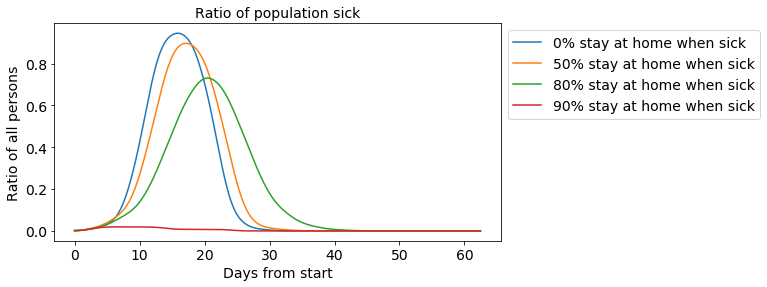

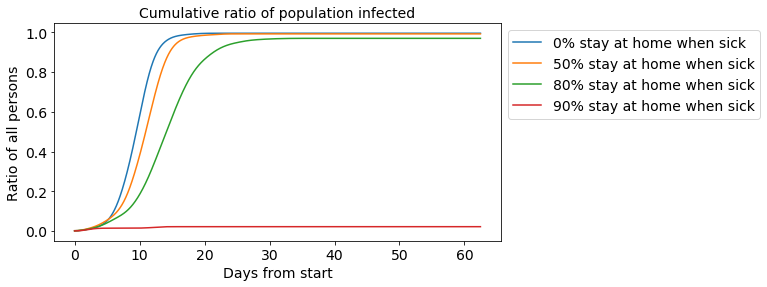

In [4]:
scenarios = []
for param in [0, 0.5, 0.8, 0.9]:
    virus = setup_virus()
    scen = setup_simulation(
        virus=virus, 
        sick_leave_ok_ratio=param,
    )
    scen['label'] = '{:0.0f}% stay at home when sick'.format(param * 100)
    scen['virus'] = virus
    scen['sim_hours'] = 1500
    scenarios.append(scen)

with Pool(processes=2) as pool: 
    scenarios = pool.map(run_simulation, scenarios)
    
# Calculate results
for scen in scenarios: 
    cumul_inf_ratio(scen)

plot_sick_ratio(scenarios)
plot_cumul_inf_ratio(scenarios)

### Vaccination ratio effect on virus spreading 
- This tests that how the ratio of persons vaccinated will slow down the virus spreading.

Scenario 30% vaccinated done in 13.7 s.
Scenario 0% vaccinated done in 16.4 s.
Scenario 70% vaccinated done in 10.7 s.
Scenario 90% vaccinated done in 8.2 s.


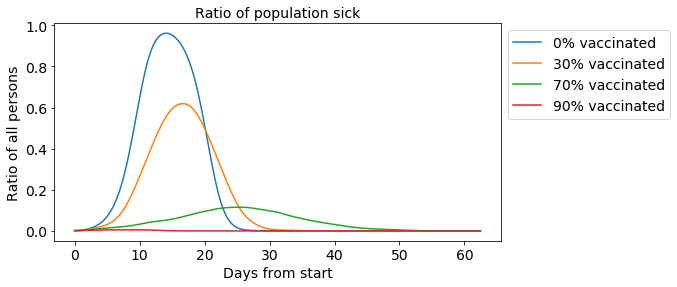

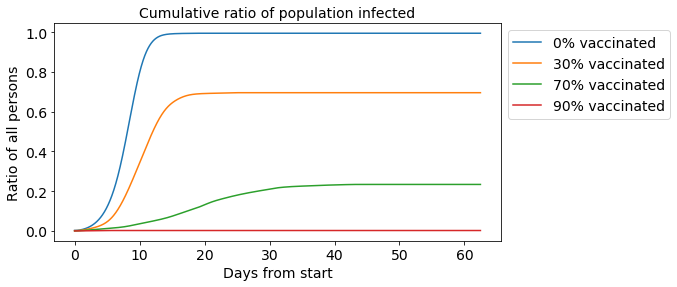

In [5]:
scenarios = []
for param in [0, 0.30, 0.7, 0.90]:
    virus = setup_virus()
    scen = setup_simulation(
        virus=virus, 
        vaccinated_ratio=param
    )
    scen['label'] = '{:0.0f}% vaccinated'.format(param * 100)
    scen['virus'] = virus
    scen['sim_hours'] = 1500
    scenarios.append(scen)

with Pool(processes=2) as pool: 
    scenarios = pool.map(run_simulation, scenarios)
    
# Calculate results
for scen in scenarios: 
    cumul_inf_ratio(scen)

plot_sick_ratio(scenarios)
plot_cumul_inf_ratio(scenarios)

### Social distancing effect on virus spreading 
This tests that how increasing the number of schools (reducing the number of persons in each school) 

Scenario 5 schools for 632 kids done in 16.4 s.
Scenario 1 schools for 632 kids done in 26.9 s.
Scenario 10 schools for 632 kids done in 17.0 s.
Scenario 20 schools for 632 kids done in 14.4 s.
Scenario 100 schools for 632 kids done in 12.9 s.


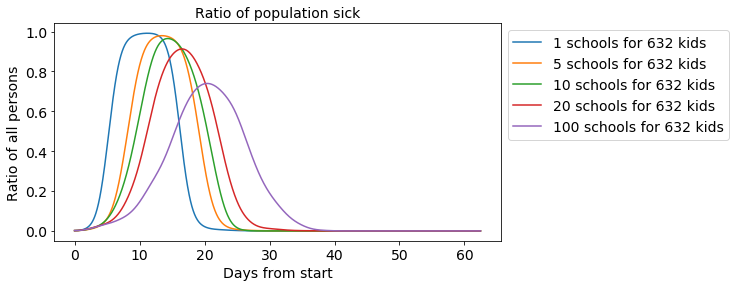

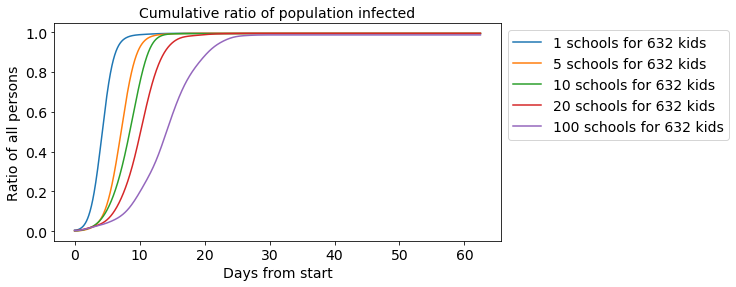

In [6]:
scenarios = []
for param in [1, 5, 10, 20, 100]:
    virus = setup_virus()
    scen = setup_simulation(
        virus=virus, 
        n_school=param, 
    )
    # Calculate number of kids
    n_kid = 0
    for person in scen['persons']: 
        if person.state['age'] < 18: 
            n_kid += 1

    scen['label'] = '{} schools for {} kids'.format(param, n_kid)
    scen['virus'] = virus
    scen['sim_hours'] = 1500
    scenarios.append(scen)

with Pool(processes=2) as pool: 
    scenarios = pool.map(run_simulation, scenarios)
    
# Calculate results
for scen in scenarios: 
    cumul_inf_ratio(scen)

plot_sick_ratio(scenarios)
plot_cumul_inf_ratio(scenarios)

### Combination of countermeasures
Compare the "do nothing" scenario to a heavy countermasures scenario

Scenario Heavy countermeasures done in 13.7 s.
Scenario Do nothing done in 16.6 s.


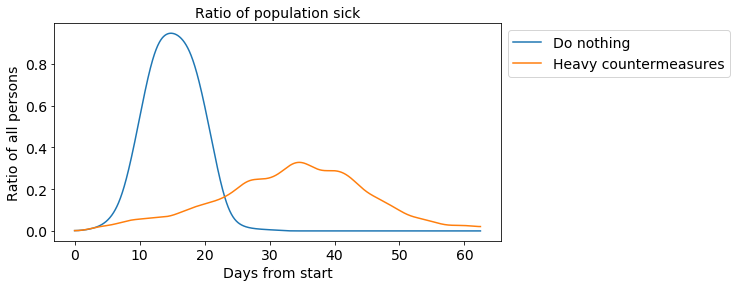

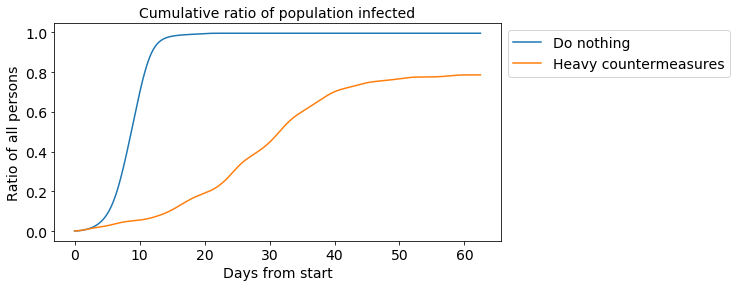

In [7]:
scenarios = []
virus = setup_virus()
scen1 = setup_simulation(virus=virus)
scen1['label'] = 'Do nothing' 
scen1['virus'] = virus
scen1['sim_hours'] = 1500
scenarios.append(scen1)

scen2 = setup_simulation(
    virus=virus,
    n_school=0,
    sick_leave_ok_ratio=0.6)
scen2['label'] = 'Heavy countermeasures' 
scen2['virus'] = virus
scen2['sim_hours'] = 1500
scenarios.append(scen2)

with Pool(processes=2) as pool: 
    scenarios = pool.map(run_simulation, scenarios)
    
# Calculate results
for scen in scenarios: 
    cumul_inf_ratio(scen)

plot_sick_ratio(scenarios)
plot_cumul_inf_ratio(scenarios)